epoch  0
     loss: nll, 3.4120280742645264
     loss: rmse, 3.0224626064300537
epoch  5
     loss: nll, 0.5609511137008667
     loss: rmse, 1.056963562965393
epoch  10
     loss: nll, 0.5494009256362915
     loss: rmse, 1.0430073738098145
epoch  15
     loss: nll, 0.5565752387046814
     loss: rmse, 1.0514506101608276
epoch  20
     loss: nll, 0.5838054418563843
     loss: rmse, 1.0889462232589722
epoch  25
     loss: nll, 0.5327475666999817
     loss: rmse, 1.0255411863327026
Early Stopped at Epoch  29


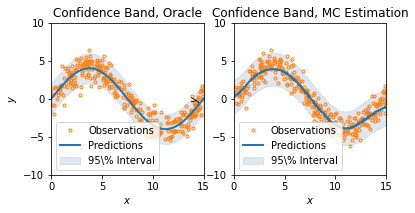

In [1]:
from src.plot_utils import plot_xy_specifyBound
import numpy as np
from scipy import stats
from src.DEFAULTS import normalZ, Upper_quant, Lower_quant, DEFAULT_mean_func, DEFAULT_layers
import matplotlib.pyplot as plt
from src.GPmodels import oneLayer_DeepGP
import torch
from src.evaluations import mu_sig_toQuants



fig, (ax1, ax2) = plt.subplots(1, 2)


X_train = np.linspace(0,15,4000)
Y_train = DEFAULT_mean_func(X_train) + 1*np.random.randn(4000)

X_val = np.linspace(0, 15, 1000)
Y_val = DEFAULT_mean_func(X_val) + 1*np.random.randn(1000)

y_pred = DEFAULT_mean_func(X_val)

y_UP1 = y_pred + 1 * normalZ.ppf(Upper_quant)
y_LO1 = y_pred + 1 * normalZ.ppf(Lower_quant)


X_train = torch.Tensor(X_train).view(-1, 1).cuda()
X_val = torch.Tensor(X_val).view(-1, 1).cuda()

Y_train = torch.Tensor(Y_train).cuda()
Y_val = torch.Tensor(Y_val).cuda()

GP_model = oneLayer_DeepGP(
    in_dim = 1, hidden_dim = 12
)


GP_model.train(
    X_train, Y_train, X_val, Y_val
)


output = GP_model.predict(X_val)

means = output[:, 0].detach()
sigs = output[:, 1].detach()

pred_quants = mu_sig_toQuants(mu = means, sig = sigs, quantiles = [Lower_quant, Upper_quant])

pred_LO = pred_quants[0].cpu().numpy()
pred_UP = pred_quants[1].cpu().numpy()

plot_xy_specifyBound(
    y_pred = y_pred,

    y_UP = y_UP1,
    y_LO = y_LO1,

    y_true = Y_val.cpu().numpy(),
    x = X_val.view(-1).cpu().numpy(),
    n_subset = 300,

    ylims = [-10, 10],
    xlims = [0, 15],

    ax = ax1,
    title = "Confidence Band, Oracle"
)

plot_xy_specifyBound(
    y_pred = means.cpu().numpy(),

    y_UP = pred_UP,
    y_LO = pred_LO,

    y_true = Y_val.cpu().numpy(),
    x = X_val.view(-1).cpu().numpy(),
    n_subset = 300,

    ylims = [-10, 10],
    xlims = [0, 15],

    ax = ax2,
    title = "Confidence Band, MC Estimation"
)

plt.show(block=True)

In [4]:
pred[0].shape

torch.Size([10, 1000])